## Step 1: Setup and Configuration
This section imports all necessary libraries and defines robust, absolute paths to our data and model directories. Using absolute paths is a best practice that prevents errors when running code from different locations or using background workers.

In [35]:
import os
import cv2
import json
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import efficientnet_b2

from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [36]:
# Paths
root_path = os.path.join('..', 'dataset', 'malaria')
train_json_path = os.path.join(root_path, 'training_stratified.json')
test_json_path = os.path.join(root_path, 'test_stratified.json')
results_path = os.path.join('..','effecientnetb2_model','efficientnet_models','grid_search_results.json')
models_dir = os.path.join('..','effecientnetb2_model','efficientnet_models')
image_path = os.path.join('..','dataset','malaria','images')
os.makedirs(models_dir, exist_ok=True)

print("Root Path:", root_path)
print("Train JSON Path:", train_json_path)
print("Test JSON Path:", test_json_path)
print("Image Path:", image_path)

Root Path: ..\dataset\malaria
Train JSON Path: ..\dataset\malaria\training_stratified.json
Test JSON Path: ..\dataset\malaria\test_stratified.json
Image Path: ..\dataset\malaria\images


In [37]:
# Function to count entries in a JSON file
def count_json_entries(file_path):
    if not os.path.exists(file_path):
        print(f"Error: The file path '{file_path}' does not exist.")
        return 0
    
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Assuming the JSON data is a list of entries
    return len(data)

# Count entries in each file
train_count = count_json_entries(train_json_path)
test_count = count_json_entries(test_json_path)

# Print the results
print(f"Number of entries in training.json: {train_count}")
print(f"Number of entries in test.json: {test_count}")

Number of entries in training.json: 1190
Number of entries in test.json: 138


In [38]:
# Load the grid search results
with open(results_path, 'r') as f:
    all_results = json.load(f)

# Convert to a DataFrame for easy analysis
results_df = pd.DataFrame(all_results)

# The 'params' column is a dictionary, let's expand it for better sorting
params_df = pd.json_normalize(results_df['params'])
results_df = pd.concat([results_df.drop('params', axis=1), params_df], axis=1)

# Sort by accuracy to find the best run
results_df = results_df.sort_values(by='best_accuracy', ascending=False).reset_index(drop=True)

print("--- Top 5 Performing Models ---")
display(results_df.head())

--- Top 5 Performing Models ---


,best_accuracy,training_time_minutes,history,lr,optimizer,batch_size,sampling,image_size
0,94.799054,47.760783,"{'train_loss': [9.133223307760138, 8.397412940...",0.0010,Adam,32,oversample,224
1,94.799054,25.002517,"{'train_loss': [16.83139763380352, 15.91469799...",0.0010,Adam,32,oversample,128
2,94.799054,48.497283,"{'train_loss': [9.836383957611886, 8.620703860...",0.0010,SGD,32,oversample,224
3,94.799054,48.624517,"{'train_loss': [9.700505482523065, 8.685548355...",0.0010,SGD,32,none,224
4,94.799054,27.238550,"{'train_loss': [17.683489924982975, 16.0491562...",0.0001,Adam,32,none,128


In [39]:
import matplotlib.pyplot as plt

def plot_training_history(history, params):
    """
    Plots the training and validation loss and accuracy curves from a history dictionary.
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    
    # Create an array for the x-axis (epochs)
    epochs = range(1, len(history['train_loss']) + 1)

    # --- Plot 1: Loss vs. Epochs ---
    ax[0].plot(epochs, history['train_loss'], label='Train Loss', color='royalblue', marker='o', linestyle='--')
    ax[0].plot(epochs, history['val_loss'], label='Validation Loss', color='darkorange', marker='o')
    ax[0].set_title('Loss Over Epochs', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=12)
    ax[0].set_ylabel('Loss', fontsize=12)
    ax[0].legend()
    ax[0].grid(True, which='both', linestyle=':', linewidth=0.5)

    # --- Plot 2: Accuracy vs. Epochs ---
    ax[1].plot(epochs, history['train_accuracy'], label='Train Accuracy', color='royalblue', marker='s', linestyle='--')
    ax[1].plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='green', marker='s')
    ax[1].set_title('Accuracy Over Epochs', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=12)
    ax[1].set_ylabel('Accuracy (%)', fontsize=12)
    ax[1].legend()
    ax[1].grid(True, which='both', linestyle=':', linewidth=0.5)

    # Create a comprehensive title for the entire figure
    param_str = ', '.join([f'{k}={v}' for k, v in params.items()])
    fig.suptitle(f'Training History for Best Model: {param_str}', fontsize=20)
    
    # Adjust layout to prevent title overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [40]:
def plot_all_grid_search_results(all_results):
    """
    Plots the validation loss and accuracy for all experiments from a grid search on a single graph.
    """
    fig, ax = plt.subplots(1, 2, figsize=(24, 10))
    
    # Define styles to cycle through to make lines distinguishable
    linestyles = ['-', '--', ':', '-.']
    markers = ['o', 's', 'v', '^', 'D', '<', '>', 'p']
    # Generate a list of distinct colors
    colors = plt.cm.get_cmap('tab20', len(all_results))

    # --- Loop through each experiment's results ---
    for i, result in enumerate(all_results):
        history = result['history']
        params = result['params']
        
        # Create a short, descriptive label for the legend
        samp_char = 'O' if params.get('sampling', 'none') == 'oversample' else 'N'
        label = f"Run {i+1}: lr={params['lr']}, optim={params['optimizer'][:3]}, size={params['image_size']}, samp={samp_char}"

        epochs = range(1, len(history['val_loss']) + 1)
        
        # Get unique styles for the plot
        style = linestyles[i % len(linestyles)]
        marker = markers[i % len(markers)]
        color = colors(i)

        # --- Plot 1: Validation Loss vs. Epochs ---
        ax[0].plot(epochs, history['val_loss'], label=label, color=color, linestyle=style, marker=marker, markersize=5)
        
        # --- Plot 2: Validation Accuracy vs. Epochs ---
        ax[1].plot(epochs, history['val_accuracy'], label=label, color=color, linestyle=style, marker=marker, markersize=5)

    # --- Formatting for the Loss Plot ---
    ax[0].set_title('Validation Loss Comparison', fontsize=18)
    ax[0].set_xlabel('Epoch', fontsize=14)
    ax[0].set_ylabel('Loss', fontsize=14)
    ax[0].grid(True, which='both', linestyle=':', linewidth=0.7)
    
    # --- Formatting for the Accuracy Plot ---
    ax[1].set_title('Validation Accuracy Comparison', fontsize=18)
    ax[1].set_xlabel('Epoch', fontsize=14)
    ax[1].set_ylabel('Accuracy (%)', fontsize=14)
    ax[1].grid(True, which='both', linestyle=':', linewidth=0.7)
    
    # --- Create a single, shared legend outside the plot area ---
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12, title="Experiments")

    # --- Overall Figure Title and Layout Adjustment ---
    fig.suptitle('Comparison of All 16 Grid Search Experiments', fontsize=24)
    fig.tight_layout(rect=[0, 0, 0.85, 0.96]) # Adjust layout to make space for the legend and title
    
    plt.show()

Plotting a comparison of all 16 experiments...


C:\Users\shera\AppData\Local\Temp\ipykernel_27908\2453710040.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(all_results))


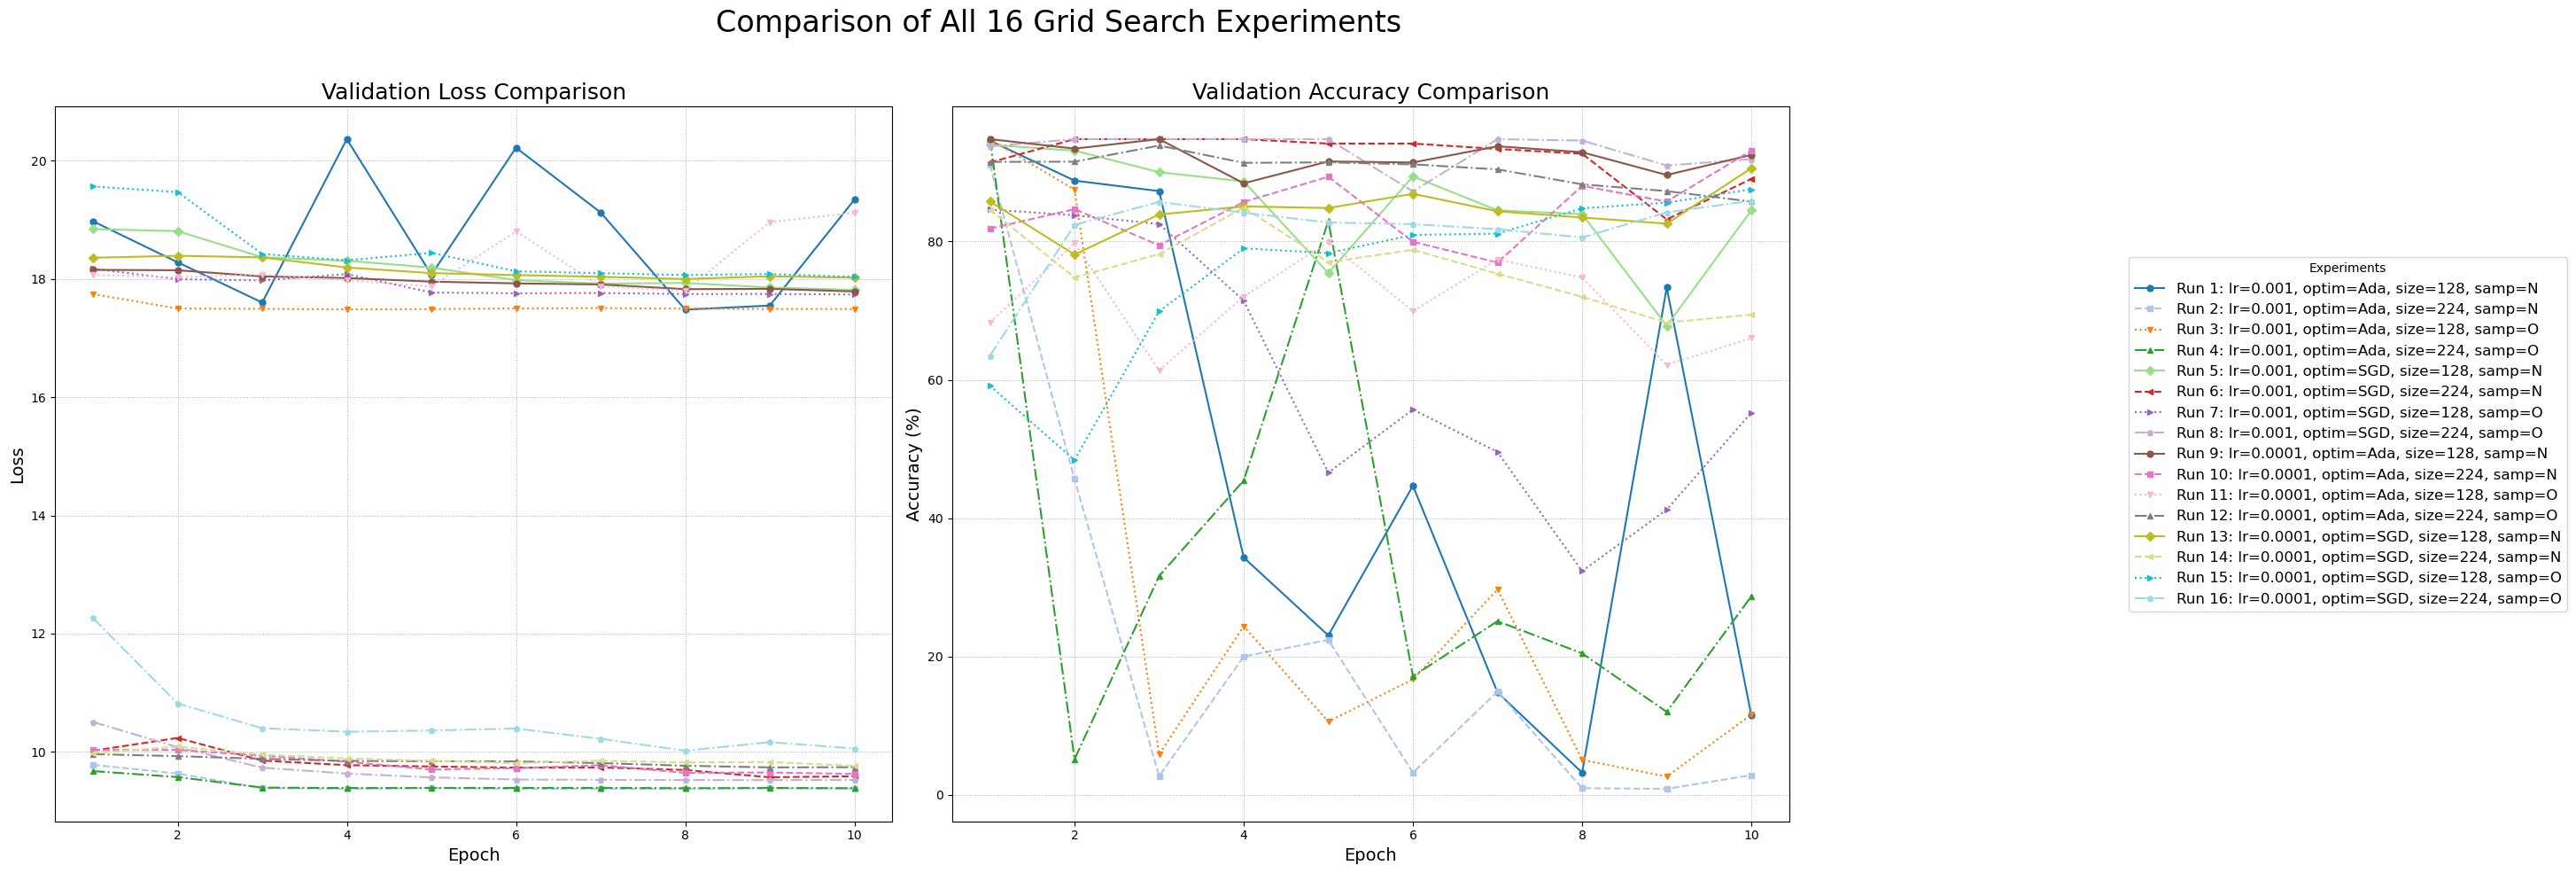

In [41]:
print(f"Plotting a comparison of all {len(all_results)} experiments...")

# Call the new function with your complete results
plot_all_grid_search_results(all_results)

## Step 2: Model and Dataset Definitions
Here we define the core components: the `MalariaDataset` class to load our specific JSON format, the `EfficientNetDetector` model, and our custom loss functions.

In [42]:
class MalariaDataset(Dataset):
    """
        class for mapping images with bounding boxes
    """
    def __init__(self, json_path, image_root, transform=None, category_map=None):
        with open(json_path, 'r') as f:
            self.entries = json.load(f)
        self.image_root = image_root
        self.transform = transform

        if category_map is None:
            all_categories = set()
            for item in self.entries:
                for obj in item['objects']:
                    all_categories.add(obj['category'])
            self.category_map = {cat: idx for idx, cat in enumerate(sorted(list(all_categories)))}
        else:
            self.category_map = category_map
        
        self.labels = []
        for item in self.entries:
            if item['objects']:
                cat = item['objects'][0]['category']
                self.labels.append(self.category_map[cat])
            else:
                self.labels.append(-1)

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        pathname_from_json = entry['image']['pathname']
        image_name = os.path.basename(pathname_from_json)
        image_full_path = os.path.join(self.image_root, image_name)

        try:
            image = Image.open(image_full_path).convert("RGB")
        except FileNotFoundError:
            print(f"Error: Image not found at {image_full_path}")
            return None # Will be filtered by collate_fn

        boxes = []
        labels = []
        for obj in entry['objects']:
            bb = obj['bounding_box']
            boxes.append([bb['minimum']['c'], bb['minimum']['r'], bb['maximum']['c'], bb['maximum']['r']])
            labels.append(self.category_map[obj['category']])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {'boxes': boxes, 'labels': labels}
        return image, target

### Model architecture

In [43]:
class EfficientNetDetector(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = efficientnet_b2(weights='IMAGENET1K_V1')
        # Replace the final fully connected layer
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity() # Remove the original classifier

        # New heads for your task
        self.classifier = nn.Linear(num_features, num_classes)
        self.bbox_head = nn.Linear(num_features, 4)

    def forward(self, x):
        features = self.backbone(x)
        class_scores = self.classifier(features)
        bbox_preds = self.bbox_head(features)
        return class_scores, bbox_preds

In [44]:
# Your loss functions and collate_fn here...
def margin_loss(class_scores, targets, margin=0.2):
    one_hot_targets = F.one_hot(targets.long(), num_classes=class_scores.size(-1)).float()
    left = F.relu(margin - class_scores) * one_hot_targets
    right = F.relu(class_scores - (1 - margin)) * (1.0 - one_hot_targets)
    return (left + right).sum(dim=-1).mean()

def bbox_loss(preds, targets):
    if preds.dim() == 1:
        preds = preds.unsqueeze(0)
    num_preds, num_targets = preds.size(0), targets.size(0)
    if num_preds > num_targets:
        padding = torch.zeros((num_preds - num_targets, 4), device=targets.device)
        targets = torch.cat([targets, padding], dim=0)
    elif num_targets > num_preds:
        padding = torch.zeros((num_targets - num_preds, 4), device=preds.device)
        preds = torch.cat([preds, padding], dim=0)
    return F.smooth_l1_loss(preds, targets)

def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, targets


## Step 3: Training and Validation Functions
This is the core logic. `train_model` handles one epoch of training. The `validate_model` function is crucially important and contains the **new, robust logic** to generate a fair, image-level ground truth for the final classification report.

In [45]:
def train_model(model, loader, optimizer, device, epoch, num_classes):
    model.train()
    running_loss, correct, total_objects = 0.0, 0, 0
    pbar = tqdm(loader, desc=f"Training Epoch {epoch}")
    
    # the loss function BCEWithLogitsLoss is ideal for multi-label tasks as it combines Sigmoid + BCE.
    # `pos_weight` forces the model to focus on rare classes by heavily penalizing mistakes on them.
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    for images, targets_list in pbar:
        if not images.numel(): continue # Skip empty batches
        images = images.to(device)
        optimizer.zero_grad()
        
        # Getting the class scores
        class_scores = model(images)
        
        # Creating a placeholder for all target labels in the batch
        all_target_labels = torch.zeros_like(class_scores).to(device)

        # Populate the multi-hot encoded tensor
        for i, target in enumerate(targets_list):
            labels = target['labels']
            if len(labels) > 0:
                all_target_labels[i, labels] = 1.0

        # Calculate loss for the whole batch at once
        loss = criterion(class_scores, all_target_labels)

        if images.size(0) > 0:
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # --- New Accuracy Calculation ---
        # Apply sigmoid to get probabilities, then threshold to get predictions
        preds = torch.sigmoid(class_scores)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0

        # Compare if the predicted multi-hot vector exactly matches the true one
        total_objects += images.size(0)
        correct += (preds == all_target_labels).all(dim=1).sum().item()

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / len(loader) if len(loader) > 0 else 0
    accuracy = 100 * correct / total_objects if total_objects > 0 else 0
    return epoch_loss, accuracy

# def validate_model(model, loader, device, num_classes, category_map, return_preds=False):
#     model.eval()
#     all_labels_for_report = []
#     all_preds_for_report = []
    
#     with torch.no_grad():
#         for images, targets_list in tqdm(loader, desc="Validating"):
#             if not images.numel(): continue
#             images = images.to(device)
            
#             # This version correctly expects two outputs from the model
#             class_scores, _ = model(images) 

#             # Get predictions by applying sigmoid and a 0.5 threshold
#             preds = torch.sigmoid(class_scores)
#             preds[preds >= 0.5] = 1
#             preds[preds < 0.5] = 0
#             all_preds_for_report.extend(preds.cpu().numpy())

#             # Create the true multi-hot labels for the batch
#             true_labels = torch.zeros_like(preds)
#             for i, target in enumerate(targets_list):
#                 labels = target.get('labels', []) # Use .get for safety
#                 if len(labels) > 0:
#                     true_labels[i, labels] = 1.0
#             all_labels_for_report.extend(true_labels.cpu().numpy())

#     if return_preds:
#         return np.array(all_labels_for_report), np.array(all_preds_for_report)
#     else:
#         # Return overall accuracy
#         accuracy = 100 * np.mean(np.array(all_labels_for_report) == np.array(all_preds_for_report))
#         return accuracy

def validate_model(model, dataloader, device, num_classes, category_map, return_preds=False):
    """
    Validates the model on the given dataloader and returns true labels and predictions.
    
    THIS VERSION IS CORRECTED FOR LIST-BASED LABELS.
    """
    model.eval()
    all_true_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            
            outputs, _ = model(images)
            _, predicted_indices = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted_indices.cpu().numpy())
            
            # --- THIS IS THE FIX ---
            # 'labels' is a list, so we extend our list of true labels directly.
            # We remove the .cpu().numpy() calls that were causing the error.
            all_true_labels.extend(labels)

    if return_preds:
        return np.array(all_true_labels), np.array(all_predictions)

## Step 4: Main Training Pipeline
This is where we put everything together. We'll define our hyperparameters, set up the datasets and dataloaders, and then run the training loop for a set number of epochs. After training, the best model is saved.

In [46]:
# # --- 1. Define Hyperparameters for our single run ---
params = {
    'lr': 0.001,
    'optimizer': 'Adam',
    'batch_size': 32,
    'image_size': 224,
    'sampling': 'oversample'
}
NUM_EPOCHS = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {DEVICE}")

# --- 2. Create Datasets and Category Map ---
transform = transforms.Compose([
    transforms.Resize((params['image_size'], params['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds = MalariaDataset(train_json_path, image_path, transform=transform)
category_map = train_ds.category_map
num_classes = len(category_map)
test_ds = MalariaDataset(test_json_path, image_path, transform=transform, category_map=category_map)

# print(f"Found {num_classes} classes: {category_map}")



# Place this code before your training loop
print("Calculating class weights for the loss function...")

# Count the occurrences of each class (positives)
# We build a multi-hot matrix for the whole dataset
multi_hot_labels = np.zeros((len(train_ds), num_classes), dtype=float)
for i, entry in enumerate(train_ds.entries):
    for obj in entry['objects']:
        cat_idx = category_map.get(obj['category'])
        if cat_idx is not None:
            multi_hot_labels[i, cat_idx] = 1.0

# Sum over the dataset to get positive counts for each class
positive_counts = multi_hot_labels.sum(axis=0)

# Calculate total number of samples
total_samples = len(train_ds)

# Calculate pos_weight for each class
# Add a small epsilon (1e-6) to avoid division by zero for classes that might not appear
pos_weight = (total_samples - positive_counts) / (positive_counts + 1e-6)

# Convert to a PyTorch tensor
pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(DEVICE)

print(f"Calculated pos_weight: {pos_weight_tensor.cpu().numpy()}")

Calculating class weights for the loss function...
Calculated pos_weight: [ 2.5416667  7.880597  14.657894   0.         3.9583333  6.6282053
  1.0517242]


In [47]:
# --- 3. Create DataLoaders (with optional oversampling) ---
sampler = None
if params['sampling'] == 'oversample':
    print("Applying weighted random oversampling...")

    # Get counts for each class. `minlength` ensures the array has a slot for every class.
    # We also filter out the `-1` labels for images that have no objects.
    class_counts = np.bincount(
        [label for label in train_ds.labels if label != -1], 
        minlength=num_classes
    )
    
    # Add a small epsilon (1e-6) to the denominator to prevent division by zero.
    class_weights = 1. / (class_counts + 1e-6)
    
    # Create sample weights, giving a weight of 0 to images with no objects.
    sample_weights = np.array([class_weights[t] if t != -1 else 0 for t in train_ds.labels])
    
    sampler = WeightedRandomSampler(torch.from_numpy(sample_weights).double(), len(sample_weights))
    # --- END OF CORRECTION ---

train_loader = DataLoader(
    train_ds,
    batch_size=params['batch_size'],
    collate_fn=custom_collate_fn,
    shuffle=True  # <-- SET SHUFFLE TO TRUE since the sampler is gone
)

test_loader = DataLoader(
    test_ds, 
    batch_size=params['batch_size'], 
    shuffle=False, 
    collate_fn=custom_collate_fn
)

# --- 4. Initialize Model and Optimizer ---
model = EfficientNetDetector(num_classes=num_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

# --- 5. Run Training Loop ---
# best_val_accuracy = 0.0
# history = {'train_loss': [], 'train_accuracy': [], 'val_accuracy': []}

# for epoch in range(1, NUM_EPOCHS + 1):
#     train_loss, train_acc = train_model(model, train_loader, optimizer, DEVICE, epoch, num_classes)
#     val_acc = validate_model(model, test_loader, DEVICE, num_classes, category_map)
    
#     history['train_loss'].append(train_loss)
#     history['train_accuracy'].append(train_acc)
#     history['val_accuracy'].append(val_acc)
    
#     print(f"Epoch {epoch} Summary: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    
#     if val_acc > best_val_accuracy:
#         best_val_accuracy = val_acc
#         save_path = os.path.join(models_dir, 'best_model.pth')
#         torch.save(model.state_dict(), save_path)
#         print(f"🎉 New best model saved to {save_path} with accuracy: {best_val_accuracy:.2f}%")

print("\n--- Training Complete ---")

Applying weighted random oversampling...

--- Training Complete ---


## Step 5: Final Evaluation and Analysis With Model Loading
Now that the model is trained, we load the best-performing version (the one saved during the epoch with the highest validation accuracy) and run a final, detailed evaluation on the test set. This gives us an unbiased assessment of its performance.

In [48]:
print(os.listdir())

['effecientnetb2.ipynb', 'effenet_analysis.ipynb', 'efficientnet_models', 'eff_got.ipynb']


In [52]:
import os
import glob
import pandas as pd
from sklearn.metrics import classification_report

# --- 1. Define Paths and Constants ---
# Make sure 'models_dir', 'DEVICE', etc., are correctly defined from your notebook
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 7 # Should match your model's output

# --- 2. Find All Model Files ---
# Use glob to find all files ending with .pth in your models directory
model_paths = glob.glob(os.path.join(models_dir, '*.pth'))
print(f"Found {len(model_paths)} models to evaluate.")

# --- 3. Create a Place to Store Results ---
results_summary = []

# --- 4. Loop Through and Evaluate Each Model (Corrected) ---
for model_path in model_paths:
    model_filename = os.path.basename(model_path)
    print(f"\n{'='*20}")
    print(f"EVALUATING MODEL: {model_filename}")
    print(f"{'='*20}")
    
    try:
        eval_model = EfficientNetDetector(num_classes=num_classes).to(DEVICE)
        checkpoint = torch.load(model_path, map_location=DEVICE)
        state_dict = checkpoint.get('model_state_dict', checkpoint)
        eval_model.load_state_dict(state_dict)
        print("Model loaded successfully.")

        y_true, y_pred = validate_model(eval_model, test_loader, DEVICE, num_classes, category_map, return_preds=True)

        # --- THIS IS THE FIX ---
        # We sort by the 'id' key inside the value dictionary.
        # We sort directly by the integer value (item[1])
        # Correctly sort directly by the integer value (item[1])
        class_names = [name for name, index in sorted(category_map.items(), key=lambda item: item[1])]
        
        report_str = classification_report(
            y_true, 
            y_pred, 
            target_names=class_names,
            zero_division=0
        )
        print("\n--- Classification Report ---")
        print(report_str)
        
        report_dict = classification_report(
            y_true, 
            y_pred, 
            target_names=class_names,
            zero_division=0,
            output_dict=True
        )
        
        results_summary.append({
            'model_name': model_filename,
            'precision': report_dict['weighted avg']['precision'],
            'recall': report_dict['weighted avg']['recall'],
            'f1-score': report_dict['weighted avg']['f1-score']
        })

    except Exception as e:
        print(f"--- 💥 FAILED to evaluate {model_filename}: {e} ---")
# --- 5. Display the Final Summary Table ---
print(f"\n{'='*30}")
print("      OVERALL MODEL COMPARISON")
print(f"{'='*30}")

if results_summary:
    summary_df = pd.DataFrame(results_summary)
    summary_df = summary_df.sort_values(by='f1-score', ascending=False).reset_index(drop=True)
    print(summary_df)
else:
    print("No models were successfully evaluated.")

Found 16 models to evaluate.

EVALUATING MODEL: model_lr_0.0001_optim_Adam_sampling_none_size_128.pth


C:\Users\shera\AppData\Local\Temp\ipykernel_27908\2819599125.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)


Model loaded successfully.
--- 💥 FAILED to evaluate model_lr_0.0001_optim_Adam_sampling_none_size_128.pth: '<' not supported between instances of 'dict' and 'dict' ---

EVALUATING MODEL: model_lr_0.0001_optim_Adam_sampling_none_size_224.pth
Model loaded successfully.


KeyboardInterrupt: 

In [ ]:
# --- 6. Save the Final Summary to a CSV File ---
# Define the path for the results file
results_csv_path = os.path.join(models_dir, 'model_evaluation_summary.csv')

if results_summary:
    # Save the DataFrame to a CSV file
    # index=False prevents pandas from writing the DataFrame index as a column
    summary_df.to_csv(results_csv_path, index=False)
    print(f"\n✅ Results summary successfully saved to:\n{results_csv_path}")
else:
    print("\nNo results to save.")


No results to save.


In [ ]:
best_model_path = os.path.join(models_dir, 'model_lr_0.0001_optim_SGD_sampling_oversample_size_128.pth')
eval_model = EfficientNetDetector(num_classes=num_classes).to(DEVICE)
checkpoint = torch.load(best_model_path, map_location=DEVICE)

# Then, extract the model's state dictionary from the checkpoint using its key.
state_dict = checkpoint['model_state_dict']

# Now, load the extracted state_dict into your model. This will work.
eval_model.load_state_dict(state_dict)
print(f"Loaded best model from {best_model_path}")

# --- 2. Get Final Predictions ---
y_true, y_pred = validate_model(eval_model, test_loader, DEVICE, num_classes, category_map, return_preds=True)

# --- 3. Generate Reports ---
class_names = [name for name, index in sorted(category_map.items(), key=lambda item: item[1])]
labels_for_report = list(range(len(class_names)))

# Classification Report
print("\n--- Classification Report ---")
report = classification_report(
    y_true, 
    y_pred, 
    target_names=class_names,
    labels=labels_for_report,
    zero_division=0
)
print(report)

C:\Users\shera\AppData\Local\Temp\ipykernel_27908\260458708.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=DEVICE)

Loaded best model from ..\effecientnetb2_model\efficientnet_models\model_lr_0.0001_optim_SGD_sampling_oversample_size_128.pth


AttributeError: 'list' object has no attribute 'cpu'

In [ ]:
import os
import glob
import pandas as pd
import torch
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Define a Reusable Plotting Function ---
def plot_and_save_confusion_matrix(cm, class_names, model_filename, save_path):
    """
    Plots and saves a confusion matrix.
    
    Args:
        cm (np.array): The confusion matrix.
        class_names (list): A list of class names for the labels.
        model_filename (str): The filename of the model for the plot title.
        save_path (str): The full path where the plot image will be saved.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', # Integer format
        cmap='Blues', 
        xticklabels=class_names, 
        yticklabels=class_names
    )
    
    plt.title(f'Confusion Matrix for: {model_filename}', fontsize=16)
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout() # Adjust layout to make room for labels
    
    # Save the figure
    plt.savefig(save_path)
    print(f"Confusion matrix plot saved to: {save_path}")
    
    # Display the plot
    plt.show()


# --- 2. Main Evaluation Loop (Updated) ---

# --- Define Paths and Constants ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 7 # Should match your model's output

# --- Find All Model Files ---
model_paths = glob.glob(os.path.join(models_dir, '*.pth'))
print(f"Found {len(model_paths)} models to evaluate.")

# --- Loop Through and Evaluate Each Model ---
for model_path in model_paths:
    model_filename = os.path.basename(model_path)
    print(f"\n{'='*30}")
    print(f"EVALUATING MODEL: {model_filename}")
    print(f"{'='*30}")
    
    try:
        # --- A. Load the Model ---
        eval_model = EfficientNetDetector(num_classes=num_classes).to(DEVICE)
        checkpoint = torch.load(model_path, map_location=DEVICE)
        state_dict = checkpoint.get('model_state_dict', checkpoint)
        eval_model.load_state_dict(state_dict)
        print("Model loaded successfully.")

        # --- B. Get Predictions ---
        y_true, y_pred = validate_model(eval_model, test_loader, DEVICE, num_classes, category_map, return_preds=True)

        # --- C. Generate and Print the Classification Report ---
        class_names = [name for name, index in sorted(category_map.items(), key=lambda item: item[1])]
        report_str = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
        print("\n--- Classification Report ---\n" + report_str)
        
        # --- D. Calculate, Plot, and Save the Confusion Matrix ---
        cm = confusion_matrix(y_true, y_pred)
        
        # Define a unique path for saving the plot
        plot_filename = model_filename.replace('.pth', '_confusion_matrix.png')
        plot_save_path = os.path.join(models_dir, plot_filename)
        
        # Call our plotting function
        plot_and_save_confusion_matrix(cm, class_names, model_filename, plot_save_path)

    except Exception as e:
        print(f"--- 💥 FAILED to evaluate {model_filename}: {e} ---")

Found 16 models to evaluate.

EVALUATING MODEL: model_lr_0.0001_optim_Adam_sampling_none_size_128.pth


C:\Users\shera\AppData\Local\Temp\ipykernel_28384\3606442704.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)


Model loaded successfully.
--- 💥 FAILED to evaluate model_lr_0.0001_optim_Adam_sampling_none_size_128.pth: 'list' object has no attribute 'cpu' ---

EVALUATING MODEL: model_lr_0.0001_optim_Adam_sampling_none_size_224.pth
Model loaded successfully.
--- 💥 FAILED to evaluate model_lr_0.0001_optim_Adam_sampling_none_size_224.pth: 'list' object has no attribute 'cpu' ---

EVALUATING MODEL: model_lr_0.0001_optim_Adam_sampling_oversample_size_128.pth
Model loaded successfully.



--- Per-Class Confusion Matrices ---

Matrix for 'difficult':
  - True Negatives (Correctly predicted 'Not Present'): 105
  - False Positives (Incorrectly predicted 'Present'): 22
  - False Negatives (Incorrectly predicted 'Not Present'): 6
  - True Positives (Correctly predicted 'Present'):  5

Matrix for 'gametocyte':
  - True Negatives (Correctly predicted 'Not Present'): 55
  - False Positives (Incorrectly predicted 'Present'): 70
  - False Negatives (Incorrectly predicted 'Not Present'): 6
  - True Positives (Correctly predicted 'Present'):  7

Matrix for 'leukocyte':
  - True Negatives (Correctly predicted 'Not Present'): 106
  - False Positives (Incorrectly predicted 'Present'): 14
  - False Negatives (Incorrectly predicted 'Not Present'): 6
  - True Positives (Correctly predicted 'Present'):  12

Matrix for 'red blood cell':
  - True Negatives (Correctly predicted 'Not Present'): 0
  - False Positives (Incorrectly predicted 'Present'): 0
  - False Negatives (Incorrectly predic

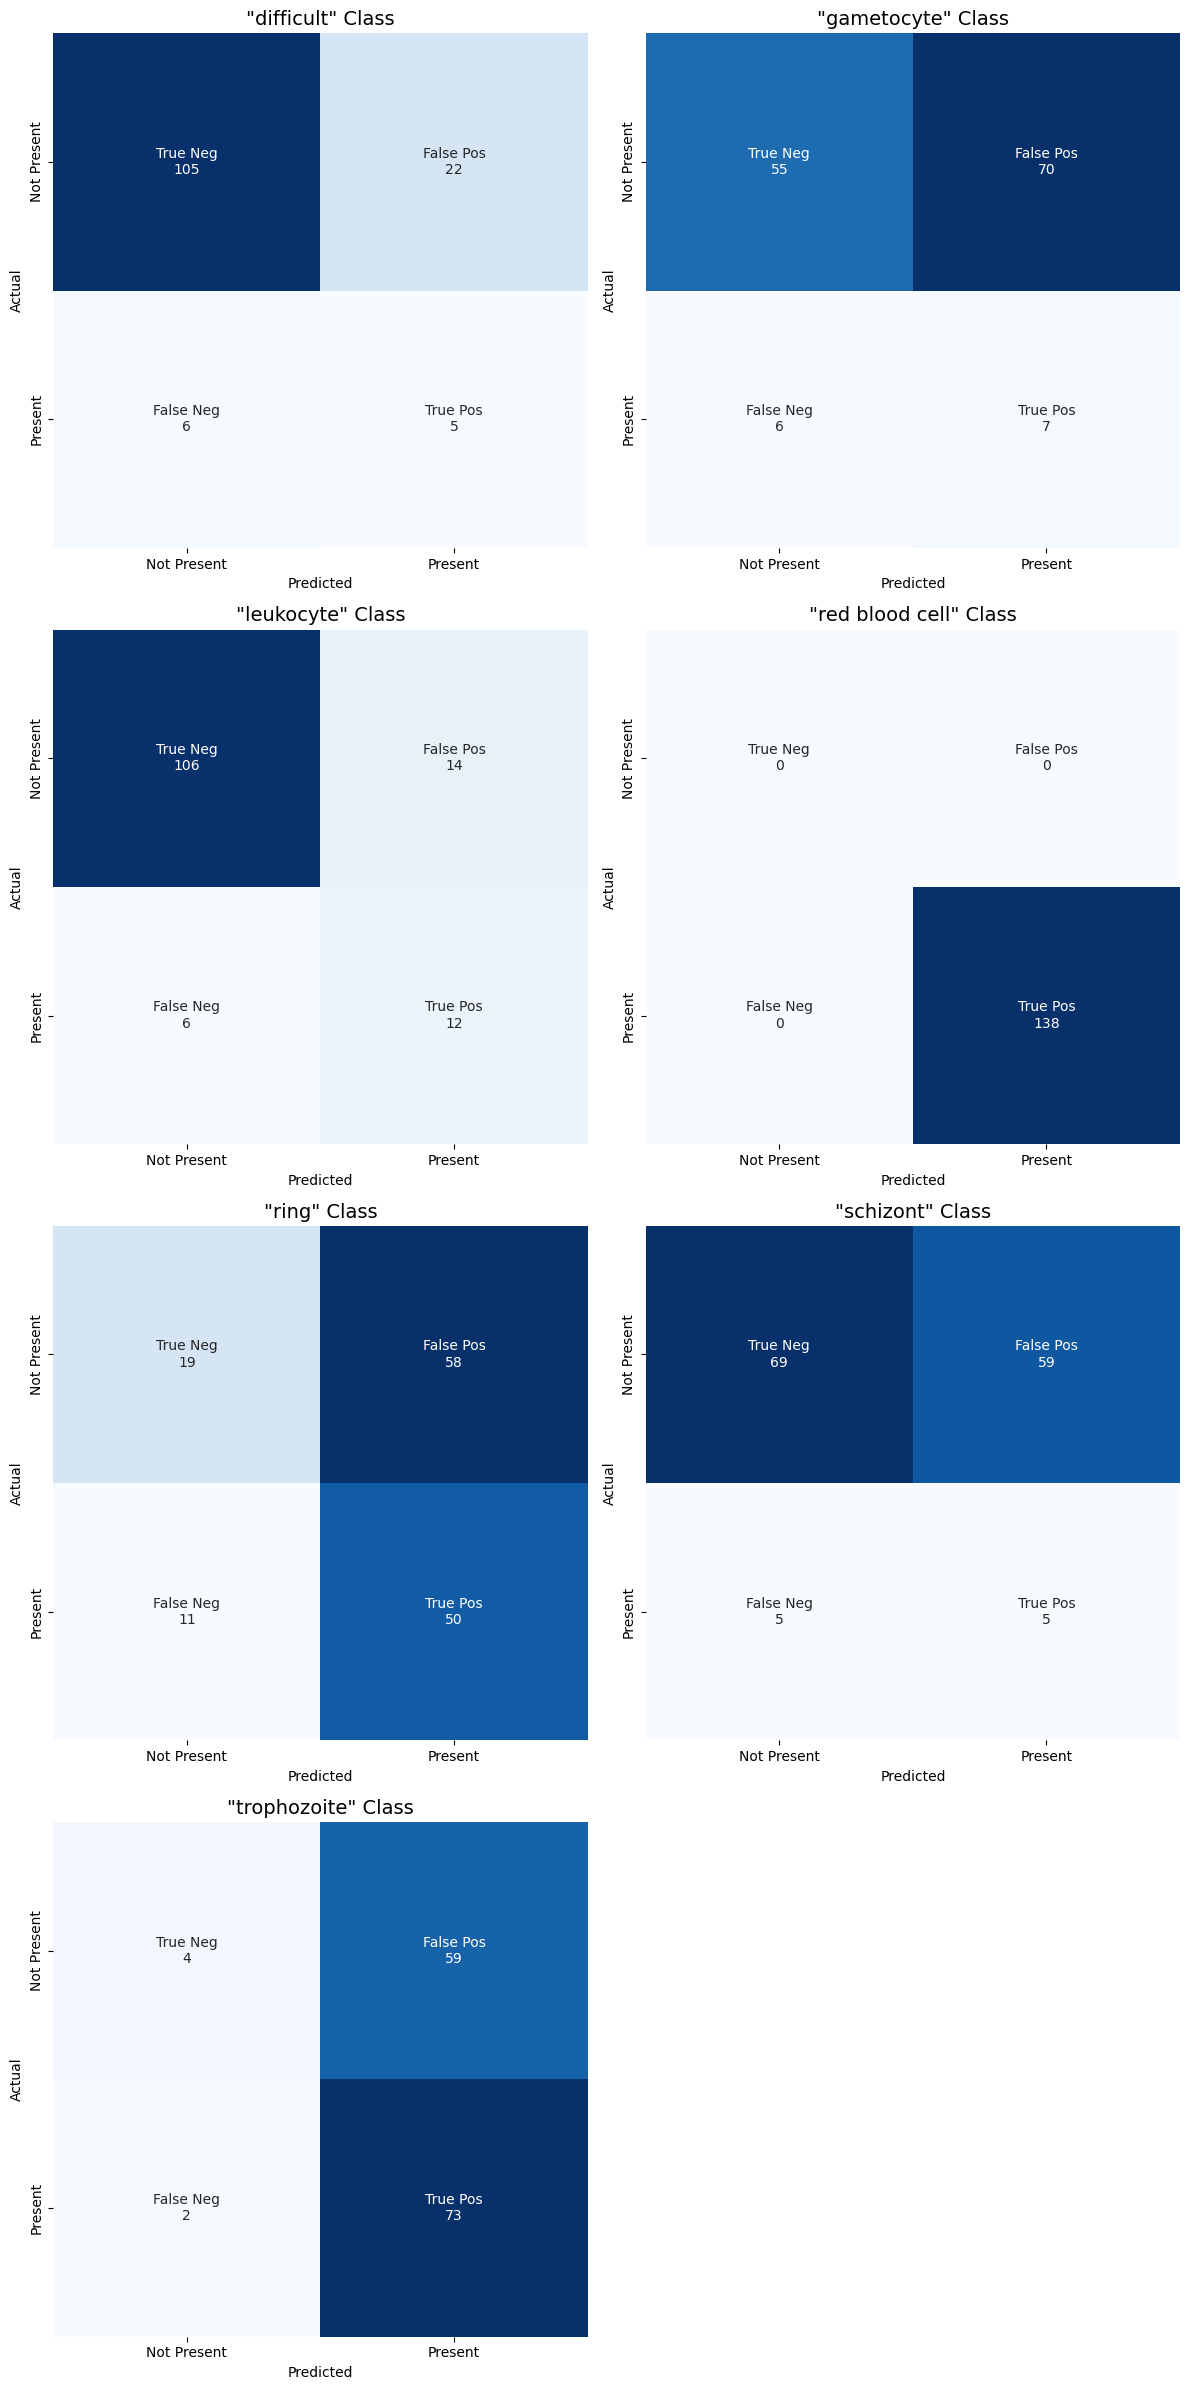

In [ ]:
# --- 1. Generate the multi-label confusion matrices ---
mcm = multilabel_confusion_matrix(y_true, y_pred, labels=labels_for_report)

# --- 2. Plot a confusion matrix for each class ---
print("\n--- Per-Class Confusion Matrices ---")
# Create a subplot for each class
# Adjust nrows and ncols based on how many classes you have
nrows = (len(class_names) + 1) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, nrows * 6))
axes = axes.flatten() # Flatten the axes array for easy iteration

for i, class_name in enumerate(class_names):
    ax = axes[i]
    # Get the 2x2 matrix for the current class
    matrix = mcm[i]
    print(f"\nMatrix for '{class_name}':")
    print(f"  - True Negatives (Correctly predicted 'Not Present'): {matrix[0, 0]}")
    print(f"  - False Positives (Incorrectly predicted 'Present'): {matrix[0, 1]}")
    print(f"  - False Negatives (Incorrectly predicted 'Not Present'): {matrix[1, 0]}")
    print(f"  - True Positives (Correctly predicted 'Present'):  {matrix[1, 1]}")

    # Format the labels for the heatmap
    group_counts = [f"{value}" for value in matrix.flatten()]
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'"{class_name}" Class', fontsize=14)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(['Not Present', 'Present'])
    ax.set_yticklabels(['Not Present', 'Present'])

# Hide any unused subplots
for i in range(len(class_names), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

### Model prediction

In [ ]:
# Create a single dictionary to hold all ground truth entries
all_entries_map = {}

# Populate the map from the training dataset
for entry in train_ds.entries:
    filename = os.path.basename(entry['image']['pathname'])
    all_entries_map[filename] = entry

# Add/overwrite with entries from the test dataset
for entry in test_ds.entries:
    filename = os.path.basename(entry['image']['pathname'])
    all_entries_map[filename] = entry

print(f"Created a lookup map with {len(all_entries_map)} total unique image entries.")

Created a lookup map with 1328 total unique image entries.


In [ ]:
from collections import Counter
import matplotlib.patches as patches

def visualize_diagnostic_prediction(
    model, image_path, all_entries_map, device, class_names, threshold=0.5
):
    """
    Performs a diagnostic prediction, providing an infection status and a
    clear comparison between predicted and actual classes.
    """
    # Define which classes indicate an infection
    parasite_classes = {'gametocyte', 'trophozoite', 'schizont', 'ring'}
    
    print(f"--- Processing image: {os.path.basename(image_path)} ---")
    image_pil = Image.open(image_path).convert("RGB")
    
    # --- 1. Get Ground Truth Data ---
    target_filename = os.path.basename(image_path)
    ground_truth_entry = all_entries_map.get(target_filename)
    ground_truth_labels = set()
    if ground_truth_entry and ground_truth_entry['objects']:
        ground_truth_labels = {obj['category'] for obj in ground_truth_entry['objects']}

    # --- 2. Preprocess and Predict ---
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image_pil).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        class_scores, _ = model(image_tensor)

    # --- 3. Decode Predictions & Determine Status ---
    # --- THE FIX IS HERE: Add .squeeze(0) to remove the batch dimension ---
    probabilities = torch.sigmoid(class_scores).squeeze(0)
    
    # Find indices where probability is above the threshold
    predicted_indices = (probabilities >= threshold).nonzero(as_tuple=True)[0]
    predicted_labels = {class_names[i] for i in predicted_indices}
    
    print("\n--- Prediction Breakdown ---")
    # This line will now work correctly
    all_scores = sorted([(class_names[i], probabilities[i].item()) for i in range(len(class_names))], key=lambda x: x[1], reverse=True)
    for class_name, score in all_scores:
        print(f"  - {class_name:<15}: {score*100:.2f}%")

    print("\n--- Ground Truth Breakdown ---")
    if ground_truth_entry and ground_truth_entry['objects']:
        gt_labels = [obj['category'] for obj in ground_truth_entry['objects']]
        frequency_counts = Counter(gt_labels)
        sorted_freq = sorted(frequency_counts.items(), key=lambda item: item[1], reverse=True)
        print("Class Frequencies:")
        for class_name, count in sorted_freq:
            print(f"  - {class_name:<15}: {count}")
    else:
        print("  - No ground truth objects listed for this image.")
    
    # Determine infection status
    predicted_status = "Infected" if not predicted_labels.isdisjoint(parasite_classes) else "Not Infected"
    actual_status = "Infected" if not ground_truth_labels.isdisjoint(parasite_classes) else "Not Infected"

    # --- 4. Print Detailed Breakdowns ---
    
    # Final Diagnosis (Infected/Not Infected)
    print("\n--- Final Diagnosis ---")
    diagnosis_correct = (predicted_status == actual_status)
    print(f"Model Diagnosis: {predicted_status} | Actual Status: {actual_status} {'✅' if diagnosis_correct else '❌'}")
    
    # Detailed Class-by-Class Comparison
    print("\n--- Prediction Summary ---")
    true_positives = predicted_labels.intersection(ground_truth_labels)
    false_positives = predicted_labels.difference(ground_truth_labels)
    false_negatives = ground_truth_labels.difference(predicted_labels)

    print(f"✅ Correctly Predicted: {', '.join(true_positives) if true_positives else 'None'}")
    print(f"❌ Missed: {', '.join(false_negatives) if false_negatives else 'None'}")
    print(f"⚠️ Incorrectly Predicted: {', '.join(false_positives) if false_positives else 'None'}")

    # --- 5. Create the side-by-side plot ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot 1: Model Prediction
    ax1.imshow(image_pil)
    ax1.set_title(f'Model Diagnosis: {predicted_status}', fontsize=16, color='green' if diagnosis_correct else 'red')
    ax1.axis('off')
    if predicted_labels:
        label_texts = [f"- {label}" for label in sorted(list(predicted_labels))]
        summary_text = "Predicted Classes:\n" + "\n".join(label_texts)
        ax1.text(0.02, 0.98, summary_text, transform=ax1.transAxes, fontsize=12,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='limegreen', alpha=0.7))
    else:
        ax1.text(0.5, 0.5, 'No classes predicted', color='white', fontsize=14, ha='center', va='center',
                 bbox=dict(facecolor='red', alpha=0.7, edgecolor='none'), transform=ax1.transAxes)

    # Plot 2: Ground Truth
    ax2.imshow(image_pil)
    ax2.set_title(f'Actual Status: {actual_status}', fontsize=16)
    ax2.axis('off')
    if ground_truth_entry and ground_truth_entry['objects']:
        for obj in ground_truth_entry['objects']:
            bb = obj['bounding_box']
            rect_gt = patches.Rectangle((bb['minimum']['c'], bb['minimum']['r']), 
                                        bb['maximum']['c'] - bb['minimum']['c'], 
                                        bb['maximum']['r'] - bb['minimum']['r'], 
                                        linewidth=3, edgecolor='gold', facecolor='none')
            ax2.add_patch(rect_gt)
            ax2.text(bb['minimum']['c'], bb['minimum']['r'] - 15, obj['category'], color='black', fontsize=12,
                     bbox=dict(facecolor='gold', alpha=0.8, edgecolor='none'))
    else:
        ax2.text(0.5, 0.5, 'No ground truth objects', color='white', fontsize=14, ha='center', va='center',
                 bbox=dict(facecolor='gray', alpha=0.7, edgecolor='none'), transform=ax2.transAxes)

    plt.tight_layout()
    plt.show()

--- Processing image: fd1302e2-3cd2-4a1a-9c13-00f810a9c41b.png ---

--- Prediction Breakdown ---
  - red blood cell : 67.23%
  - ring           : 58.20%
  - leukocyte      : 58.14%
  - gametocyte     : 56.46%
  - schizont       : 54.58%
  - trophozoite    : 52.03%
  - difficult      : 51.76%

--- Ground Truth Breakdown ---
Class Frequencies:
  - red blood cell : 54
  - ring           : 1

--- Final Diagnosis ---
Model Diagnosis: Infected | Actual Status: Infected ✅

--- Prediction Summary ---
✅ Correctly Predicted: ring, red blood cell
❌ Missed: None
⚠️ Incorrectly Predicted: difficult, leukocyte, gametocyte, trophozoite, schizont


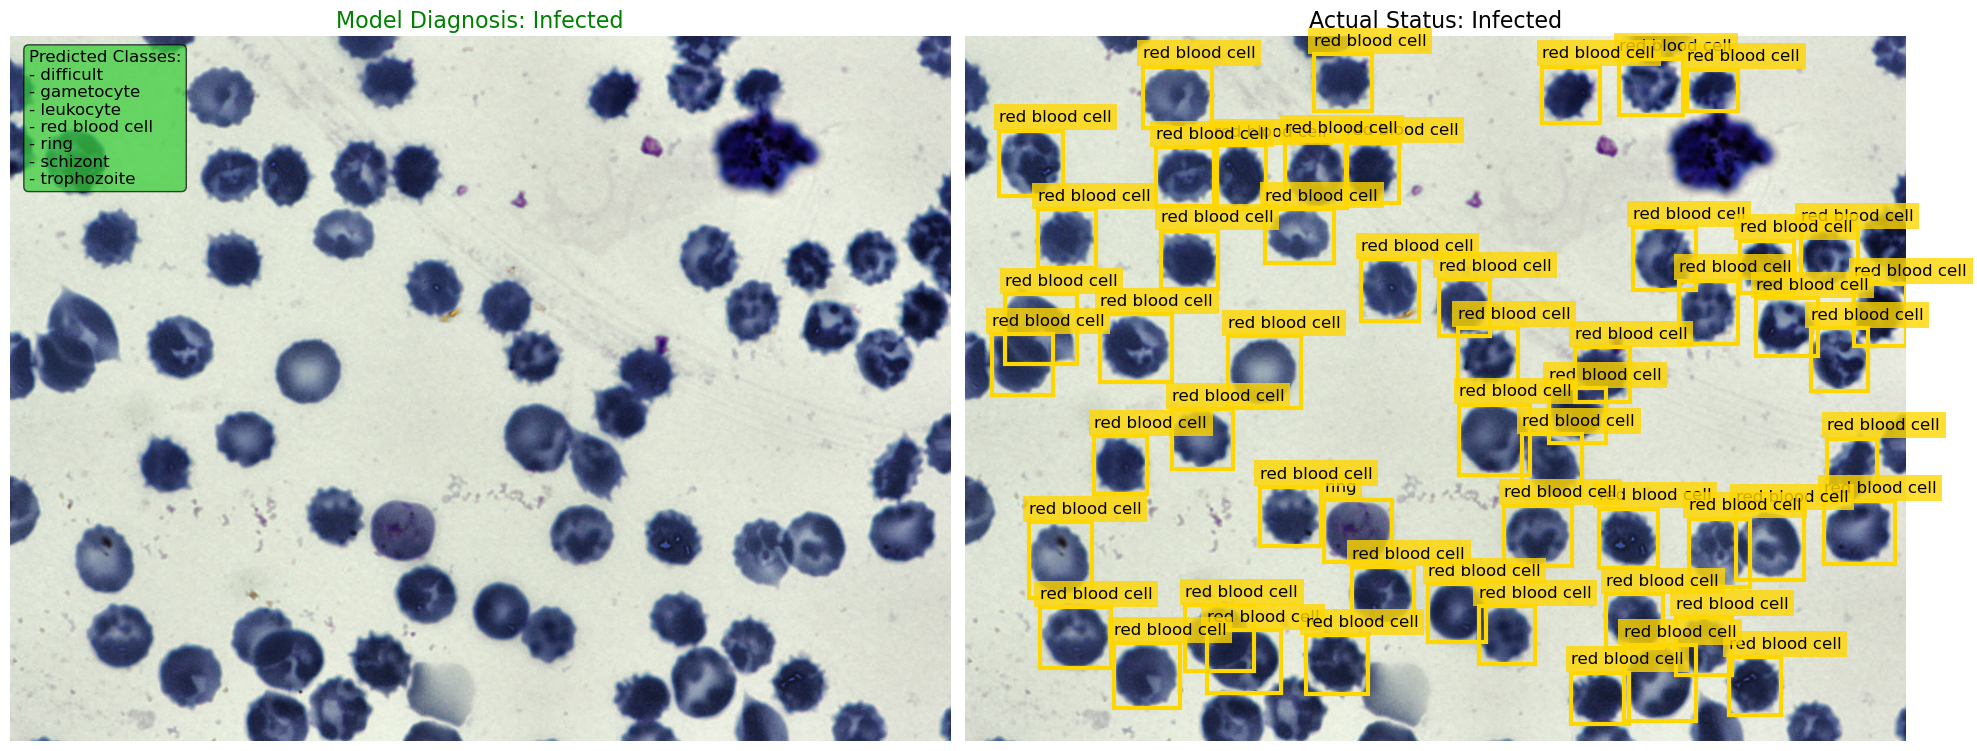

In [ ]:
# The function call is the same
my_image_path = os.path.join(image_path, 'fd1302e2-3cd2-4a1a-9c13-00f810a9c41b.png')

visualize_diagnostic_prediction(
    model=eval_model,
    image_path=my_image_path,
    all_entries_map=all_entries_map,
    device=DEVICE,
    class_names=class_names,
    threshold=0.5 # You can adjust this threshold
)

## Gradcam

In [ ]:
class GradCAM:
    """
    A robust Grad-CAM class that properly manages and removes hooks.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Store hook handles to be able to remove them later
        self.handles = []
        self._register_hooks()

    def _capture_activations(self, module, input, output):
        self.activations = output.detach()

    def _capture_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def _register_hooks(self):
        # Register hooks and store their handles
        handle_forward = self.target_layer.register_forward_hook(self._capture_activations)
        handle_backward = self.target_layer.register_full_backward_hook(self._capture_gradients)
        self.handles.extend([handle_forward, handle_backward])

    def remove_hooks(self):
        # Use the stored handles to remove the hooks
        for handle in self.handles:
            handle.remove()

    def generate_heatmap(self, model_output, class_idx):
        if class_idx is None:
            class_idx = model_output.argmax(dim=1)
        
        self.model.zero_grad()
        model_output[0, class_idx].backward(retain_graph=True)
        
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(self.activations, dim=1).squeeze().cpu()
        heatmap = F.relu(heatmap)
        heatmap /= (torch.max(heatmap) + 1e-8)
        
        return heatmap.numpy()

In [ ]:
def visualize_with_gradcam(
    model, image_path, device, class_names, threshold=0.5
):
    """
    Makes a prediction and visualizes the result with a Grad-CAM heatmap,
    ensuring hooks are always removed.
    """
    # --- Set up Grad-CAM and ensure cleanup ---
    target_layer = model.backbone.features[-1]
    grad_cam = GradCAM(model, target_layer)
    
    try:
        # --- All the visualization logic goes inside the 'try' block ---
        print(f"--- Processing image: {os.path.basename(image_path)} ---")
        image_pil = Image.open(image_path).convert("RGB")
        
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image_tensor = transform(image_pil).unsqueeze(0).to(device)

        model.eval()
        class_scores = model(image_tensor)
        probabilities = torch.sigmoid(class_scores[0])
        
        all_scores = sorted(
            [(class_names[i], prob.item()) for i, prob in enumerate(probabilities)],
            key=lambda x: x[1],
            reverse=True
        )

        print("\n--- Prediction Breakdown ---")
        for class_name, score in all_scores:
            print(f"  - {class_name:<15}: {score*100:.2f}%")
            
        top_class_idx = probabilities.argmax().item()
        top_class_name = class_names[top_class_idx]
        
        print(f"\nGenerating Grad-CAM for the top prediction: '{top_class_name}'")

        heatmap = grad_cam.generate_heatmap(class_scores, class_idx=top_class_idx)
        
        heatmap_resized = cv2.resize(heatmap, (image_pil.width, image_pil.height))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

        image_np = np.array(image_pil)
        superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap_colored, 0.4, 0)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        ax1.imshow(image_pil)
        ax1.set_title("Original Image")
        ax1.axis('off')
        
        ax2.imshow(superimposed_img)
        confidence = probabilities[top_class_idx].item() * 100
        ax2.set_title(f"Grad-CAM: Predicted '{top_class_name}' ({confidence:.2f}%)")
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()

    finally:
        # --- This line will run no matter what, cleaning up the hooks ---
        grad_cam.remove_hooks()
        print("--- Grad-CAM hooks removed. ---")

In [ ]:
# Specify the path to an image you want to test
my_image_path = os.path.join(image_path, 'fd1302e2-3cd2-4a1a-9c13-00f810a9c41b.png')

# Call the new visualization function
visualize_with_gradcam(
    model=eval_model, 
    image_path=my_image_path,
    device=DEVICE,
    class_names=class_names
)

--- Processing image: fd1302e2-3cd2-4a1a-9c13-00f810a9c41b.png ---
--- Grad-CAM hooks removed. ---


RuntimeError: a Tensor with 7 elements cannot be converted to Scalar